# 12wk-1: 선인장 이미지 분류

최규빈  
2024-12-03

<a href="https://colab.research.google.com/github/guebin/MP2024/blob/main/posts/12wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

# 2. imports

In [300]:
import numpy as np
import pandas as pd 
import zipfile
import os
import PIL.Image
import matplotlib.pyplot as plt
#---#
import datasets
import transformers
import torchvision.transforms
import evaluate
import torch

# 3. Kaggle

## A. ref

ref: <https://www.kaggle.com/c/aerial-cactus-identification>

## B. 압축해제

## C. 데이터 살펴보기

# 4. Logits의 이해

## A. 로짓의 의미

`-` 로짓의 이해: 클래스가 2개인 자료에 대한 분류문제를 푼다고 하자.
3개의 observation/examples 에 대한 로짓값이 아래와 같다고 하자.

In [129]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
logits

로짓값은 일반적으로 $(n,k)$의 차원을 가지며 여기에서 $n$은 observation의
숫자, $k$는 클래스의 숫자를 의미한다. 이 예제의 경우는 $n=8$, $k=2$인
경우이다.

여기에서 각 observation에 대한 로짓값이 의미하는 바를 살펴보면 아래와
같다.

1.  첫 번째 관측값 (`[2.7346244, -3.1177292]`):

-   첫 번째 클래스에 대한 확신 정도: `2.7346244`
-   두 번째 클래스에 대한 확신 정도: `-3.1177292`

1.  두 번째 관측값 (`[2.7103324,  -3.1362345]`):

-   첫 번째 클래스에 대한 확신 정도: `2.7103324`
-   두 번째 클래스에 대한 확신 정도: `-3.1362345`

…

1.  마지막 관측값 (\[`-2.7668718`, `3.0918367`\]):

-   첫 번째 클래스에 대한 확신 정도: `-2.7668718`
-   두 번째 클래스에 대한 확신 정도: `3.0918367`

## B. 로짓 $\to$ 예측클래스

`-` 로짓 $\to$ 예측클래스의 과정을 살펴보자.

1.  첫 번째 관측값: $2.7346244 > -3.1177292$ $\Rightarrow$ 첫 번째
    클래스로 예측

2.  두 번째 관측값: $2.7103324 > -3.1362345$ $\Rightarrow$ 첫 번째
    클래스로 예측

…

1.  마지막 관측값: $-2.7668718 < 3.0918367$ $\Rightarrow$ 두 번째
    클래스로 예측

`-` 이것은 아래를 이용하여 구할수도 있다.

## C. 로짓 $\to$ 예측확률

`-` 로짓 $\to$ 예측확률의 과정을 살펴보자.

${\boldsymbol u}=\begin{bmatrix} u_1 & \dots & u_k\end{bmatrix}$를
고정된 observation에 대한 logits값 이라고 하자. 이때 각 클래스에 속할
확률값은 아래와 같이 구한다.

$$\text{prob} =\left[\frac{\exp(u_1)}{\exp(u_1)+\dots+\exp(u_k)}, \cdots,  \frac{\exp(u_k)}{\exp(u_1)+\dots+\exp(u_k)}\right]$$

`-` 이 확률은 아래를 통하여 구할수도 있다.

# 5. 평가지표

## A. accuracy 계산

`-` accuracy의 계산: `logits`와 `labels`가 아래와 같이 주어졌다고 하자.

In [343]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [327]:
predictions = logits.argmax(axis=1)
predictions

accuracy는 아래와 같이 계산할 수 있다.

In [328]:
(predictions == references).sum()/8

In [329]:
(predictions == references).mean()

이걸 아래와 같이 계산할 수도 있다.

In [330]:
acc = evaluate.load("accuracy")
acc.compute(predictions=predictions, references=references)

## B. recall 계산

`-` 경우에 따라서 1을 얼마나 더 잘맞추는지 알고 싶은 경우도 있다.

$$\frac{\text{실제 라벨이 1인 관측치 중 올바르게 예측된 관측치수}}{\text{실제 라벨이 1인 관측치 수}}$$

In [313]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [322]:
predictions = logits.argmax(axis=1)
predictions

In [323]:
(predictions[labels==1] == 1).mean()

이것을 아래와 같이 구할수도 있다.

In [325]:
rec = evaluate.load("recall")
rec.compute(predictions=predictions, references=references)

## C. auc 계산

`-` accuracy 이외의 평가지표들

-   <https://guebin.github.io/MP2023/posts/12wk-46.html> // 시험에는 X

`-` AUC: 클래스간의 불균형이 있을때 유의미한 평가지표

In [316]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [318]:
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
prediction_scores = probabilities[:,1]
prediction_scores

-   0.4 이상부터는 1로 판단한다면? $\to$ 다 맞춘거아니야?

In [320]:
roc_auc = evaluate.load("roc_auc")
roc_auc.compute(references= references, prediction_scores= prediction_scores)

`# 예제1` – 시각화

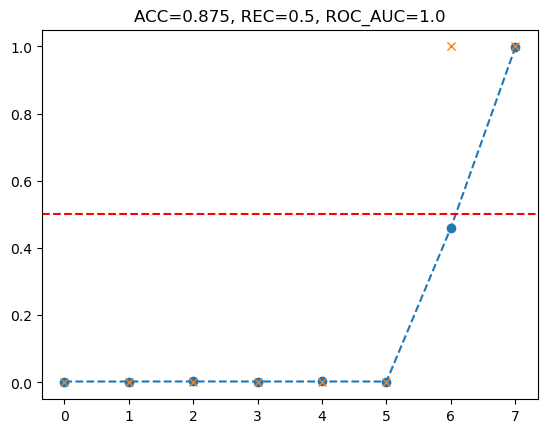

In [299]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
labels = np.array([0,0,0,0,0,0,1,1])
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
plt.plot(probabilities[:,1],'--o')
plt.plot(labels,'x')
plt.axhline(y=0.5, color='red', linestyle='--')
roc_auc = evaluate.load("roc_auc")
acc = evaluate.load("accuracy")
rec = evaluate.load("recall")
results = {
    'accuracy': acc.compute(predictions= logits.argmax(axis=1), references=labels)['accuracy'],
    'recall': rec.compute(predictions= logits.argmax(axis=1), references=labels)['recall'],
    'roc_auc': roc_auc.compute(references= labels, prediction_scores= probabilities[:,1])['roc_auc']
}
plt.title(f"ACC={results['accuracy']}, REC={results['recall']}, ROC_AUC={results['roc_auc']}")

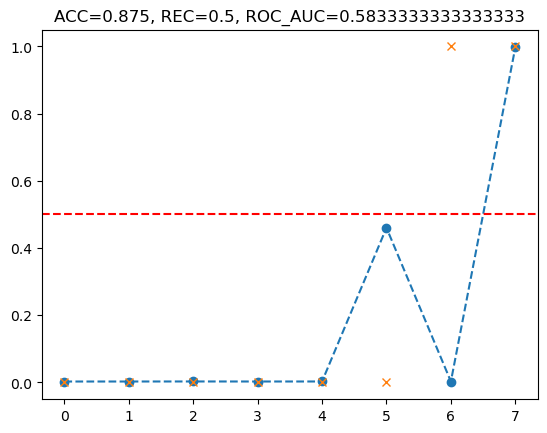

In [301]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 0.0657177, -0.0930362],     
     [ 2.7398622, -3.1098123],
     [-2.7668718,  3.0918367]]
)
labels = np.array([0,0,0,0,0,0,1,1])
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
plt.plot(probabilities[:,1],'--o')
plt.plot(labels,'x')
plt.axhline(y=0.5, color='red', linestyle='--')
roc_auc = evaluate.load("roc_auc")
acc = evaluate.load("accuracy")
rec = evaluate.load("recall")
results = {
    'accuracy': acc.compute(predictions= logits.argmax(axis=1), references=labels)['accuracy'],
    'recall': rec.compute(predictions= logits.argmax(axis=1), references=labels)['recall'],
    'roc_auc': roc_auc.compute(references= labels, prediction_scores= probabilities[:,1])['roc_auc']
}
plt.title(f"ACC={results['accuracy']}, REC={results['recall']}, ROC_AUC={results['roc_auc']}")

# 6. 분석

`-` `train.csv`를 pandas로

In [10]:
train_csv = pd.read_csv("./data/train.csv")
train_csv

In [11]:
test_csv = pd.read_csv("./data/sample_submission.csv")
test_csv

## A. 예쁜(?) 정석 코드

*Step1: Data*

In [418]:
ctx_train = datasets.Dataset.from_pandas(train_csv)
ctx_test = datasets.Dataset.from_pandas(test_csv).remove_columns(['has_cactus'])

In [419]:
ctx_train = ctx_train.map(lambda example: {'path': f'./data/train/{example['id']}'})
ctx_test = ctx_test.map(lambda example: {'path': f'./data/test/{example['id']}'})

Map: 100%|████████████████████████| 4000/4000 [00:00<00:00, 92217.97 examples/s]

In [420]:
ctx = datasets.DatasetDict({'train':ctx_train,'test':ctx_test})
ctx

In [421]:
compose('./data/train/0004be2cfeaba1c0361d39e2b000257b.jpg')

In [422]:
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224),
])
def w_trans(examples):
    dct = dict()
    try: 
        dct['labels'] = torch.tensor(examples['has_cactus']).long()
    except: 
        pass 
    dct['pixel_values'] = torch.stack(list(map(compose,examples['path']))).float() # 명확하게
    return dct 

In [423]:
ctx = ctx.with_transform(w_trans)
ctx

In [424]:
ctx['train'][:2]

*Step2: Model*

In [425]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

*Step3: Train*

In [426]:
data_collator = transformers.DefaultDataCollator()
data_collator

In [427]:
# single_batch = [ctx['train'][0],ctx['train'][1]]
# single_batch = [ctx['test'][0],ctx['test'][1]]
# model(**data_collator(single_batch))

In [428]:
ctx

In [429]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    prediction_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    #---#
    accuracy = evaluate.load("accuracy")
    recall = evaluate.load("recall")
    roc_auc = evaluate.load("roc_auc")
    dct1 = accuracy.compute(predictions=predictions, references=labels)
    dct2 = recall.compute(predictions=predictions, references=labels)
    dct3 = roc_auc.compute(prediction_scores=prediction_scores, references=labels)
    return dct1|dct2|dct3
args = transformers.TrainingArguments(
    output_dir="./model/ctx",
    remove_unused_columns=False,
    #---#
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    #metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"
)
trainer = transformers.Trainer(
    model=model,
    args=args,
    data_collator=data_collator,
    train_dataset=ctx['train'].select(range(1000)),
    eval_dataset=ctx['train'].select(range(1000,1500)),
    compute_metrics=compute_metrics,
)

In [430]:
ctx

In [431]:
trainer.train()

*Step4: Prediction*

In [432]:
out = trainer.predict(ctx['test'])
out 

In [433]:
logits = out.predictions
prob = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
prob

In [434]:
test_csv['has_cactus'] = prob 
test_csv

*Step1 ~ Step4*

In [436]:
train_csv = pd.read_csv("./data/train.csv")
test_csv = pd.read_csv("./data/sample_submission.csv")
#--#
# Step1: Data
ctx_train = datasets.Dataset.from_pandas(train_csv)
ctx_test = datasets.Dataset.from_pandas(test_csv).remove_columns(['has_cactus'])
ctx_train = ctx_train.map(lambda example: {'path': f'./data/train/{example['id']}'})
ctx_test = ctx_test.map(lambda example: {'path': f'./data/test/{example['id']}'})
ctx = datasets.DatasetDict({'train':ctx_train,'test':ctx_test})
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224),
])
def w_trans(examples):
    dct = dict()
    try: 
        dct['labels'] = torch.tensor(examples['has_cactus']).long()
    except: 
        pass 
    dct['pixel_values'] = torch.stack(list(map(compose,examples['path']))).float() # 명확하게
    return dct 
ctx = ctx.with_transform(w_trans)
# Step2: Model 
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
)
# Step3: Train 
data_collator = transformers.DefaultDataCollator()
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    prediction_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    #---#
    accuracy = evaluate.load("accuracy")
    recall = evaluate.load("recall")
    roc_auc = evaluate.load("roc_auc")
    dct1 = accuracy.compute(predictions=predictions, references=labels)
    dct2 = recall.compute(predictions=predictions, references=labels)
    dct3 = roc_auc.compute(prediction_scores=prediction_scores, references=labels)
    return dct1|dct2|dct3
trainer = transformers.Trainer(
    model=model,
    args=transformers.TrainingArguments(
        output_dir="./model/ctx",
        remove_unused_columns=False,
        #---#
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        warmup_ratio=0.1,
        logging_steps=10,
        load_best_model_at_end=True,
        #metric_for_best_model="accuracy",
        push_to_hub=False,
        report_to="none"),
    data_collator=data_collator,
    train_dataset=ctx['train'].select(range(1000)),
    eval_dataset=ctx['train'].select(range(1000,1500)),
    compute_metrics=compute_metrics,
)
trainer.train()
# Step4: Prediction
out = trainer.predict(ctx['test'])
def update(out,test_csv):
    logits = out.predictions
    prob = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    test_csv['has_cactus'] = prob
    return test_csv
test_csv = update(out,test_csv)

Map: 100%|████████████████████████| 4000/4000 [00:00<00:00, 91609.69 examples/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

## B. 자유로운 코드

*Step1: Datasets*

In [408]:
train_csv = pd.read_csv("./data/train.csv")
test_csv = pd.read_csv("./data/sample_submission.csv")
ctx_train = datasets.Dataset.from_pandas(train_csv.assign(path = train_csv.id.map(lambda x: f'./data/train/{x}')))
ctx_test = datasets.Dataset.from_pandas(test_csv.assign(path = test_csv.id.map(lambda x: f'./data/test/{x}'))).remove_columns(['has_cactus'])
ctx = datasets.DatasetDict({'train':ctx_train, 'test':ctx_test})
ctx

*Step2~3 과정의 간보기*

In [416]:
## 간보기코드
single_batch = [ctx['train'][0],ctx['train'][1]]
single_batch
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224),
])
def collate_fn(single_batch):
    dct = dict()
    dct['pixel_values'] = torch.stack(list(map(compose,[o['path'] for o in single_batch]))).float()
    try: 
        dct['labels'] = torch.tensor([o.get('has_cactus') for o in single_batch]).long() # 이거안하면 에러남
    except: 
        pass 
    return dct 
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
)
model(**collate_fn(single_batch))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

*Step1~4*

In [438]:
train_csv = pd.read_csv("./data/train.csv")
test_csv = pd.read_csv("./data/sample_submission.csv")
#--#
# Step1: Data 
ctx_train = datasets.Dataset.from_pandas(train_csv.assign(path = train_csv.id.map(lambda x: f'./data/train/{x}')))
ctx_test = datasets.Dataset.from_pandas(test_csv.assign(path = test_csv.id.map(lambda x: f'./data/test/{x}'))).remove_columns(['has_cactus'])
ctx = datasets.DatasetDict({'train':ctx_train, 'test':ctx_test})
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224),
])
# Step2: Model
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
)
# Step3: Trainer -> train 
def collate_fn(single_batch):
    dct = dict()
    dct['pixel_values'] = torch.stack(list(map(compose,[o['path'] for o in single_batch]))).float()
    try: 
        dct['labels'] = torch.tensor([o.get('has_cactus') for o in single_batch]).long() # 이거안하면 에러남
    except: 
        pass 
    return dct 
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    prediction_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    #---#
    accuracy = evaluate.load("accuracy")
    recall = evaluate.load("recall")
    roc_auc = evaluate.load("roc_auc")
    dct1 = accuracy.compute(predictions=predictions, references=labels)
    dct2 = recall.compute(predictions=predictions, references=labels)
    dct3 = roc_auc.compute(prediction_scores=prediction_scores, references=labels)
    return dct1|dct2|dct3
trainer = transformers.Trainer(
    model=model,
    args=transformers.TrainingArguments(
        output_dir="./model/ctx",
        remove_unused_columns=False,
        #---#
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        warmup_ratio=0.1,
        logging_steps=10,
        load_best_model_at_end=True,
        #metric_for_best_model="accuracy",
        push_to_hub=False,
        report_to="none"),
    data_collator=collate_fn,
    train_dataset=ctx['train'].select(range(1000)),
    eval_dataset=ctx['train'].select(range(1000,1500)),
    compute_metrics=compute_metrics,
)
trainer.train()
# Step4: Prediction
out = trainer.predict(ctx['test'])
def update(out,test_csv):
    logits = out.predictions
    prob = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    test_csv['has_cactus'] = prob
    return test_csv
test_csv = update(out,test_csv)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.